# Abs Likelihood

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()

## Model

- $p(y \mid x) = \delta(y-\mathrm{abs}(x))$
- infer gaussian $x$ prior $\mathcal{N}(r,v)$ from its abs value 
$y = \mathrm{abs}(x) \in \mathbb{R}_+$
- $Z =  \int dx\, p(y\mid x) e^{-\frac{1}{2} a x^2 + b x} =  \sum_{x \in \pm y} e^{-\frac{1}{2} a x^2 + b x}$

In [2]:
from tramp.likelihoods import AbsLikelihood

## Posterior

In [3]:
def run_posterior(y, r, v):
    likelihood = AbsLikelihood(np.array([y]))
    a, b = 1/v, r/v
    r_hat, v_hat = likelihood.compute_backward_posterior(a, b, y)
    return dict(a=a, b=b, r_hat=r_hat, v_hat=v_hat)

In [4]:
from ml_physics_utils import Task, DataFrameResultHandler
from ml_physics_utils.notebook import progressbar
from ml_physics_utils.plot import qplot
logger.setLevel(logging.ERROR)


result_handler = DataFrameResultHandler()
task = Task(run_posterior, y=[0, 1, 2], v = [0.5, 2], r = np.linspace(-10,10,101))
task.run(result_handler, on_progress=None)
df = result_handler.get_dataframe()

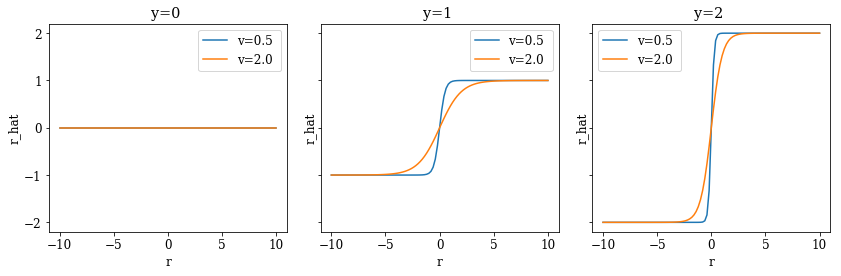

In [5]:
qplot(df, x="r", y="r_hat", color="v", column="y")

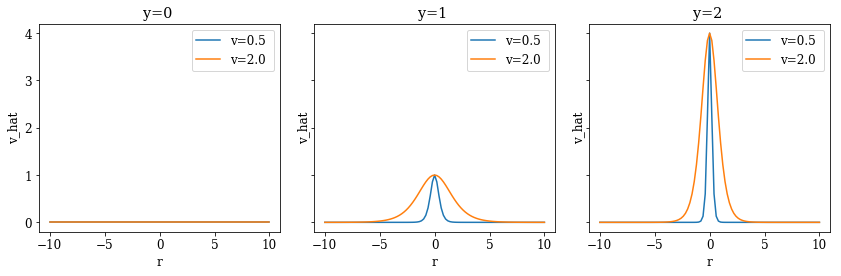

In [6]:
qplot(df, x="r", y="v_hat", color="v", column="y")

In [7]:
result_handler = DataFrameResultHandler()
task = Task(run_posterior, y=np.linspace(0,5,51), v = [0.5, 2], r = [-1,0,1])
task.run(result_handler, on_progress=None)
df = result_handler.get_dataframe()

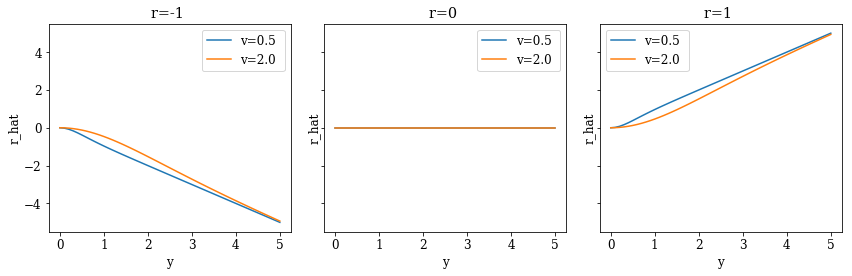

In [8]:
qplot(df, x="y", y="r_hat", color="v", column="r")

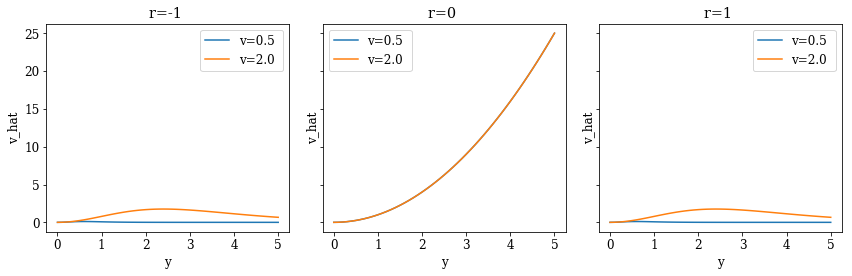

In [9]:
qplot(df, x="y", y="v_hat", color="v", column="r")

## Error function

Bad value : $a\tau - 1 < 0$ ie $ a = \frac{1}{v} < \frac{1}{\tau}$ ie $v > \tau$

$\tau$ supposed to be the second moment of $x$ so it makes sense !

In [10]:
def run_error(tau, v_scaled):
    v = v_scaled * tau
    a = 1/v
    if (a * tau - 1 < 0):
        return dict(a=a, v=v)
    s = np.sqrt(a * (a * tau - 1))
    likelihood = AbsLikelihood(np.array([1]))
    error = likelihood.compute_backward_error(a, tau)
    error_scaled = error/tau
    return dict(a=a, v=v, s=s, error_scaled=error_scaled, error=error)

In [11]:
csv_file = "data/likelihood_abs_error.csv"
try:
    df = pd.read_csv(csv_file)
except:
    result_handler = DataFrameResultHandler()
    task = Task(run_error, tau=[0.1, 1.0, 10.], v_scaled = np.linspace(0,1,51)[1:])
    with progressbar() as on_progress:
        task.run(result_handler, on_progress)
    df = result_handler.get_dataframe()
    df.to_csv(csv_file, index=False)

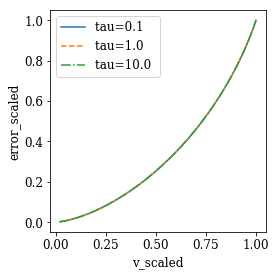

In [12]:
qplot(
    df, x="v_scaled", y="error_scaled", linestyle="tau", xlog=False
)

## Numerical stability


In [13]:
# test initial condition a=tau
likelihood = AbsLikelihood(y=np.ones(1))
for tau in [1., 2.]:
    print(f"tau={tau}")
    print(likelihood.compute_backward_posterior(az=tau, bz=0., y=+1))
    print(likelihood.compute_backward_error(az=tau+1e-15,tau=tau))
    print(likelihood.compute_backward_error(az=tau-1e-15,tau=tau))
    print()

tau=1.0
(0.0, 1.0)
0.9999999999999971
1.0000000000000013

tau=2.0
(0.0, 1.0)
0.16411407378467885
0.16411407378467904

